In [15]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import os
import numpy as np
import datetime
from tensorflow import keras
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

path = "../../dane/8CPU_20RAM/3600s/7_merged.csv"

In [16]:
# Załaduj dane
df = pd.read_csv(path)

In [17]:
# nie stosujemy one-hod encoding (kolumny z 0 i 1) bo zwiększy to bardzo czas obliczen
for col in ['replicaId', 'endpointUrl_methods']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [18]:
# Dodajemy skalowanie dla wybranych kolumn
features_to_scale = ['queueSizeForward_methods', 'queueSizeBack_methods',
                     'cpuUsage_stock', 'memoryUsage_stock',
                     'applicationTime_trading', 'databaseTime_trading',
                     'numberOfSellOffers_trading', 'numberOfBuyOffers_trading']
scaler = StandardScaler() #StandardScaler()MinMaxScaler
for col in features_to_scale:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

In [19]:
# Kodowanie kolumny 'test'
le_test = LabelEncoder()
df['test'] = le_test.fit_transform(df['test'])

In [20]:
# Wybór cech
features = [
            # 'timestamp',
            # 'apiTime_methods',
            # 'applicationTime_methods',
            # 'databaseTime_methods',
            # 'endpointUrl_methods',
            # 'queueSizeForward_methods',
            # 'queueSizeBack_methods',
            'cpuUsage_stock',
            'memoryUsage_stock',
            # 'applicationTime_trading',
            # 'databaseTime_trading',
            # 'numberOfSellOffers_trading',
            # 'numberOfBuyOffers_trading',
            # 'cpuUsage_traffic',
            # 'memoryUsage_traffic',
            # 'replicaId'
            ]
df_features = df[features]

# Kopiowanie danych
df_encoded = df_features.copy()
df_encoded['test'] = df['test']

In [21]:
def create_windows(X, y, window_size, step_size):
    X_windows = []
    y_windows = []

    # Przesuń okno po danych
    for i in range(0, len(X) - window_size, step_size):
        # Utwórz okno danych
        X_window = X.iloc[i:i + window_size]
        # Utwórz etykietę dla okna (etykieta ostatniej obserwacji w oknie)
        y_window = y.iloc[i + window_size]

        X_windows.append(X_window.values)
        y_windows.append(y_window)

    return np.array(X_windows), np.array(y_windows)

In [22]:
# Stwórz puste listy do przechowywania danych treningowych i testowych
X_train = []
X_test = []
y_train = []
y_test = []

In [23]:
window_size = 5000
step_size = 1000
# Dla każdego unikalnego pudełka
for box in df_encoded['test'].unique():
    # Wybierz tylko rekordy dla tego pudełka
    box_data = df_encoded[df_encoded['test'] == box]
    
    # Oblicz punkt podziału (80% danych)
    split_point = int(len(box_data) * 0.8)
    
    # Dodaj pierwsze 80% rekordów do danych treningowych
    X_train_box = box_data.drop('test', axis=1).iloc[:split_point]
    y_train_box = box_data['test'].iloc[:split_point]
    
    # Dodaj ostatnie 20% rekordów do danych testowych
    X_test_box = box_data.drop('test', axis=1).iloc[split_point:]
    y_test_box = box_data['test'].iloc[split_point:]
    
    # Stwórz okienka dla danych treningowych
    X_train_windows, y_train_windows = create_windows(X_train_box, y_train_box, window_size, step_size)
    
    # Stwórz okienka dla danych testowych
    X_test_windows, y_test_windows = create_windows(X_test_box, y_test_box, window_size, step_size)
    
    # Dodaj okienka do list
    X_train.append(X_train_windows)
    y_train.append(y_train_windows)
    X_test.append(X_test_windows)
    y_test.append(y_test_windows)

In [24]:
# Połączenie danych treningowych dla wszystkich pudełek
X_train_combined = np.concatenate(X_train, axis=0)
y_train_combined = np.concatenate(y_train, axis=0)

In [25]:
# Zakodowanie etykiet w formacie one-hot encoding
y_train_combined_encoded = to_categorical(y_train_combined, num_classes=len(df['test'].unique()))

In [26]:
def create_model():
    model = Sequential()
    model.add(GRU(25, input_shape=(window_size, X_train_combined.shape[2])))
    model.add(Dense(len(df['test'].unique()), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
model_path = 'model3.h5'
# if os.path.exists(model_path):
#     model = load_model(model_path)
# else:
# Define TensorBoard
log_dir = "log3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Hyperparameter tuning
model = KerasClassifier(build_fn=create_model, verbose=1)

batch_size = [5, 10, 15, 30, 50, 75, 100, 125, 150]
epochs = [3, 5, 10, 15, 20, 25, 30]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2)

X_test_combined = np.concatenate(X_test, axis=0)
y_test_combined = np.concatenate(y_test, axis=0)
y_test_encoded_combined = to_categorical(y_test_combined, num_classes=len(df['test'].unique()))

validation_data=(X_test_combined, y_test_encoded_combined)
# validation_split=0.2
grid.fit(X_train_combined, y_train_combined_encoded, validation_data=validation_data, callbacks=[es, tensorboard_callback])
grid.best_estimator_.model.save(model_path)
 

C:\Users\tomas\AppData\Local\Temp\ipykernel_18968\3458216033.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=1)


Epoch 1/3
274/274 [==============================] - 272s 982ms/step - loss: 1.2848 - accuracy: 0.4181 - val_loss: 2.9439 - val_accuracy: 0.2273
Epoch 2/3
274/274 [==============================] - 238s 868ms/step - loss: 0.9980 - accuracy: 0.4876 - val_loss: 3.3049 - val_accuracy: 0.2682
Epoch 3/3
274/274 [==============================] - 40s 144ms/step - loss: 6.2817 - accuracy: 0.0775
Epoch 1/3
274/274 [==============================] - 256s 925ms/step - loss: 1.4871 - accuracy: 0.3918 - val_loss: 3.0794 - val_accuracy: 0.2212
Epoch 2/3
274/274 [==============================] - 240s 875ms/step - loss: 1.0662 - accuracy: 0.5592 - val_loss: 3.5543 - val_accuracy: 0.2091
Epoch 3/3
274/274 [==============================] - 32s 113ms/step - loss: 6.0015 - accuracy: 0.0000e+00
Epoch 1/5
274/274 [==============================] - 222s 802ms/step - loss: 1.3500 - accuracy: 0.3925 - val_loss: 2.8493 - val_accuracy: 0.2061
Epoch 2/5
274/274 [==============================] - 256s 936ms/ste

In [ ]:
for i in range(len(X_test)):
    y_test_encoded = to_categorical(y_test[i], num_classes=len(df['test'].unique()))
    score = grid.score(X_test[i], y_test_encoded)
    print(f"Test {i+1}: Score = {score}")

NameError: name 'grid' is not defined

In [ ]:
# Convert the cv_results_ attribute to a pandas DataFrame
cv_results_df = pd.DataFrame(grid.cv_results_)

# Print the DataFrame
print(cv_results_df)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time   
0      658.166197     10.378567        36.394636        0.170090  \
1     1137.424427      5.417606        35.902685        0.412537   
2     2149.581906      1.473666        35.119349        0.141431   
3     2360.288319      3.940970        34.001041        0.064274   
4     3322.579326    969.476140        35.416072        0.168774   
..            ...           ...              ...             ...   
58     274.459493      0.096020         4.218702        0.031754   
59     383.228098     27.218673         4.264232        0.004493   
60     380.605811     28.264212         4.246052        0.006807   
61     395.645000     15.447009         4.273965        0.019360   
62     395.034569     18.942567         4.179348        0.265252   

   param_batch_size param_epochs                             params   
0                 5            3     {'batch_size': 5, 'epochs': 3}  \
1                 5            5     {'ba

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

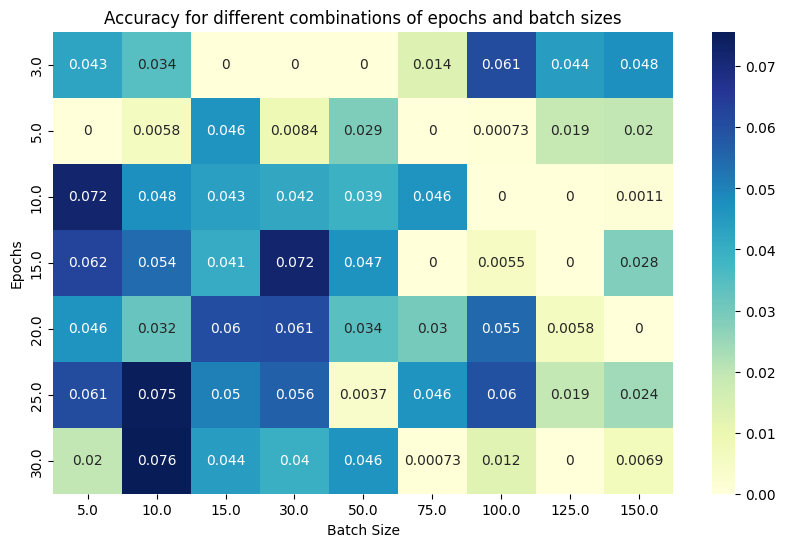

In [ ]:
# Add the parameter columns for the x/y axes
cv_results_df['param_epochs'] = cv_results_df['param_epochs'].astype(float)
cv_results_df['param_batch_size'] = cv_results_df['param_batch_size'].astype(float)

# Pivot the DataFrame to the wide format needed for the heatmap
pivot_table = cv_results_df.pivot_table(values='mean_test_score', index='param_epochs', columns='param_batch_size')

# Draw the heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Accuracy for different combinations of epochs and batch sizes')
plt.xlabel('Batch Size')
plt.ylabel('Epochs')
plt.show()